## Hierarchical Wasserstein Alignment (HiWA)

_Aim:_ Decompose data into potential clusters and then find global alignment across two datasets by leveraging clustering structure.

_Paper describing HiWA:_ John Lee, Max Dabagia, E Dyer, C Rozell: Hierarchical Wasserstein Alignment for Multimodal Distributions, May 2019.

#### In this demo there are steps to:

- Dimensionality reduction to first simplify problem
- Clustering data to feed labels into HiWA
- Alignment between clusters and then global alignment with HiWA

In [1]:
# Importnecessary packages

import numpy as np
from src import utils, hiwa
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Example A - Motor cortex during reaching movements (NHP)
_Data collected by:_ Matthew Perich, Lee Miller Lab (Northwestern)

#### Step 0. Load datasets and reach direction labels

In [2]:
# Load the datasets from a .mat file
#T_te, T_tr, X_te, X_tr, Y_te, Y_tr = utils.load_data('data\\mihi_demo.mat')
T_te, T_tr, X_te, X_tr, Y_te, Y_tr = utils.load_data('mihi_demo.mat')
T_te, T_tr = T_te.squeeze(), T_tr.squeeze()

#### Step 1. Apply initial dimensionality reduction

In [3]:
# Apply initial dimensionality reduction (n_components)
Y_te_3d = FactorAnalysis(n_components=3).fit_transform(utils.remove_const_cols(Y_te))
X_tr_3d = utils.map_X_3D(X_tr)
X_transform = np.linalg.pinv(X_tr_3d) @ X_tr

#### Step 2. Align data with HiWA

In [4]:
# Fit the model and transform the source dataset
t1 = time.time()

# This indicates to the model it should compute a low-d embedding with isomap, and that the parameter datasets will not be normalized
hwa = hiwa.HiWA(dim_red_method=Isomap(n_components=2, n_neighbors=12, eigen_solver='dense'), normalize=True)

# Fit the model, also passing in the correct rotation in Rgt since we can calculate it in this case (for computing error metrics)
# Note that we can provide the low-d mapping for either the source or target; the model will calculate whatever isn't provided
hwa.fit(Y_te_3d, T_te, X_tr_3d, T_tr, Y_transform=X_transform, Rgt=utils.LS_oracle(utils.map_X_3D(X_te), Y_te_3d))

# Transform the dataset with the learned rotation
Y_te_rec = hwa.transform(Y_te_3d)
t2 = time.time()
print('Time elapsed: {:.5} seconds'.format(t2 - t1))

Time elapsed: 10.37 seconds


#### Step 3. Evaluate performance metrics (R2 and target accuracy)

In [5]:
# Evaluate decoding accuracy after alignment
r2_hwa = utils.eval_R2(Y_te_rec[:,0:2], X_te)
print('R2 Value: {:.4}'.format(r2_hwa))

# Evaluate nearest neighbors classification accuracy before alignment
nbrs = NearestNeighbors()
nbrs.fit(Y_te_3d)
idx = nbrs.kneighbors(X_tr_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa_prealign = (T_te[idx] == T_tr).sum() / T_tr.shape[0]
print('NN Accuracy (Before): {:.2%}'.format(nn_hwa_prealign))

# Evaluate nearest neighbors classification accuracy after alignment
nbrs = NearestNeighbors()
nbrs.fit(Y_te_rec)
idx = nbrs.kneighbors(X_tr_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa = (T_te[idx] == T_tr).sum() / T_tr.shape[0]
print('NN Accuracy (After): {:.2%}'.format(nn_hwa))

R2 Value: 0.6295
NN Accuracy (Before): 24.40%
NN Accuracy (After): 40.29%


#### Step 4. Visualize results

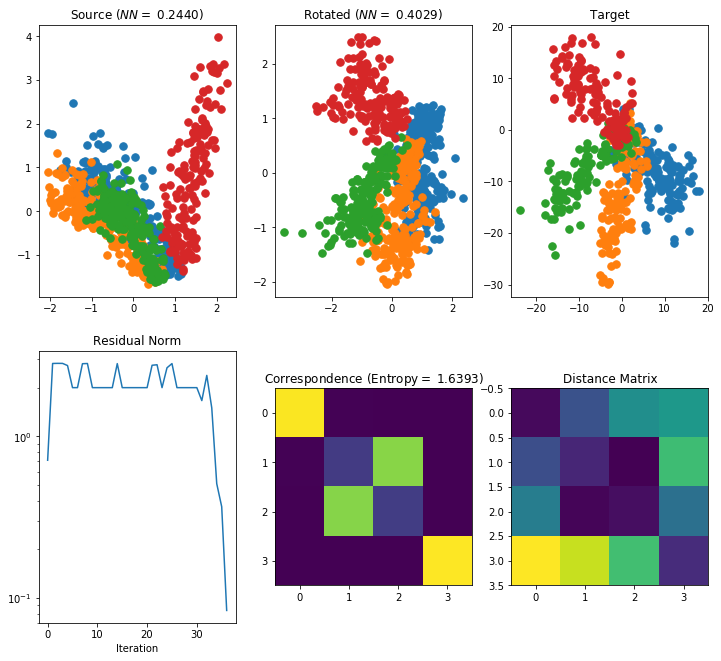

In [6]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(12, 11))
plt.subplot(2, 3, 1)
plt.title('Source ($NN = $ %.4f)' %nn_hwa_prealign)
utils.color_data(Y_te_3d, T_te)
plt.subplot(2, 3, 2)
plt.title('Rotated ($NN = $ %.4f)' %nn_hwa)
utils.color_data(Y_te_rec, T_te)
plt.subplot(2, 3, 3)
plt.title('Target')
utils.color_data(X_tr, T_tr)
ax = plt.subplot(2, 3, 4)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(2, 3, 5)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(2, 3, 6)
plt.title('Distance Matrix')
c = plt.imshow(hwa.diagnostics['C'])

### Example B - Neural recordings from rat dorsal striatum over a 24 hour period
_Data collected by_: Sam Funderburk, Keith Hengen Lab (WUSL)

#### Step 0. Load data

In [7]:
# Load the datasets from a numpy archive
#with np.load('data\\sleep_day1_60s.npz') as day1z:
with np.load('sleep_day1_60s.npz') as day1z:    
    ft1 = day1z['firing_times_d1']
    labels1 = day1z['labels_d1']
#with np.load('data\\sleep_day2_60s.npz') as day2z:
with np.load('sleep_day2_60s.npz') as day2z:   
    ft2 = day2z['firing_times_d2']
    labels2 = day2z['labels_d2']

#### Step 1. Dimensionality reduction

In [8]:
# Apply initial dimensionality reduction
pca = PCA(n_components=3)
ft1_3d = pca.fit_transform(ft1)
ft2_3d = pca.fit_transform(ft2)

#### Step 2. Align datasets with HiWA

In [9]:
# Fit the model and transform the source dataset
t1 = time.time()
hwa = hiwa.HiWA(dim_red_method=PCA(n_components=2), normalize=True)
ft1_rec = hwa.fit_transform(ft1_3d, labels1, ft2_3d, labels2)
t2 = time.time()

print('Time elapsed: {:.4f} seconds'.format(t2 - t1))

Time elapsed: 25.1009 seconds


#### Step 3. Compute Nearest Neighbor (NN) accuracy

In [10]:
nbrs = NearestNeighbors()
nbrs.fit(ft1_3d)
idx = nbrs.kneighbors(ft2_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa_prealign = (labels1[idx] == labels2).sum() / labels2.shape[0]

nbrs = NearestNeighbors()
nbrs.fit(ft1_rec)
idx = nbrs.kneighbors(ft2_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa = (labels1[idx] == labels2).sum() / labels2.shape[0]

print('NN Accuracy (Before): {:.2%}'.format(nn_hwa_prealign))
print('NN Accuracy (After): {:.2%}'.format(nn_hwa))

NN Accuracy (Before): 84.86%
NN Accuracy (After): 80.83%


#### Step 4. Visualize results

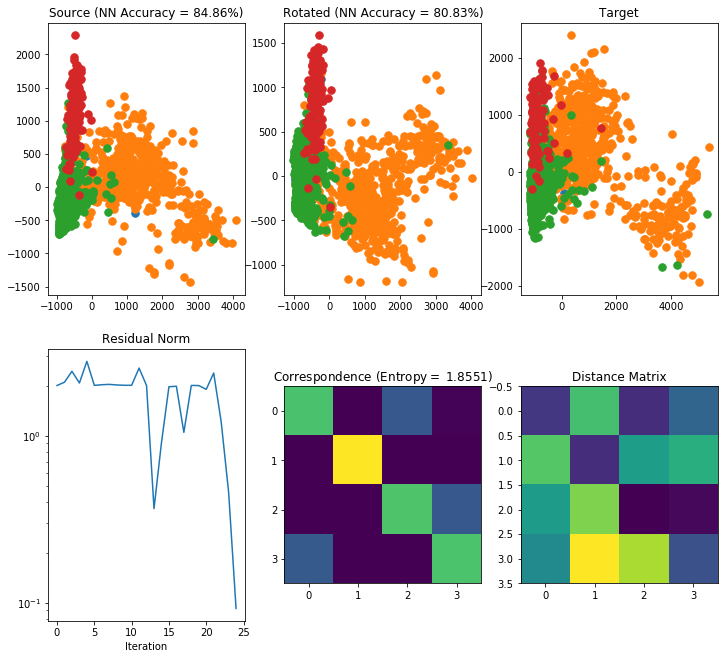

In [11]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(12, 11))
plt.subplot(2, 3, 1)
plt.title('Source (NN Accuracy = {:.2%})'.format(nn_hwa_prealign))
utils.color_data(ft1_3d, labels1)
plt.subplot(2, 3, 2)
plt.title('Rotated (NN Accuracy = {:.2%})'.format(nn_hwa))
utils.color_data(ft1_rec, labels1)
plt.subplot(2, 3, 3)
plt.title('Target')
utils.color_data(ft2_3d, labels2)
ax = plt.subplot(2, 3, 4)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(2, 3, 5)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(2, 3, 6)
plt.title('Distance Matrix')
c = plt.imshow(hwa.diagnostics['C'])

### Example C - Cluster via Gaussian Mixture Model (GMM) before alignment with HiWA

#### Step 1. Cluster via Gaussian Mixture Model

In [12]:
gmm = GaussianMixture(n_components=4)
gmm.fit(ft1_3d)
labels1_gmm = gmm.predict(ft1_3d)
gmm.fit(ft2_3d)
labels2_gmm = gmm.predict(ft2_3d)

#### Step 2. Align clustered datasets with HiWA

In [13]:
# Fit the model and transform the source dataset
t1 = time.time()
hwa = hiwa.HiWA(dim_red_method=PCA(n_components=2), normalize=True)
ft1_rec = hwa.fit_transform(ft1_3d, labels1_gmm, ft2_3d, labels2_gmm)
t2 = time.time()

print('Time elapsed: {:.4f} seconds'.format(t2 - t1))

Time elapsed: 59.0506 seconds


In [14]:
nbrs = NearestNeighbors()
nbrs.fit(ft1_3d)
idx = nbrs.kneighbors(ft2_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa_prealign = (labels1[idx] == labels2).sum() / labels2.shape[0]

nbrs = NearestNeighbors()
nbrs.fit(ft1_rec)
idx = nbrs.kneighbors(ft2_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa = (labels1[idx] == labels2).sum() / labels2.shape[0]

print('NN Accuracy (Before): {:.2%}'.format(nn_hwa_prealign))
print('NN Accuracy (After): {:.2%}'.format(nn_hwa))

NN Accuracy (Before): 84.86%
NN Accuracy (After): 26.39%


#### Step 3. Visualize results

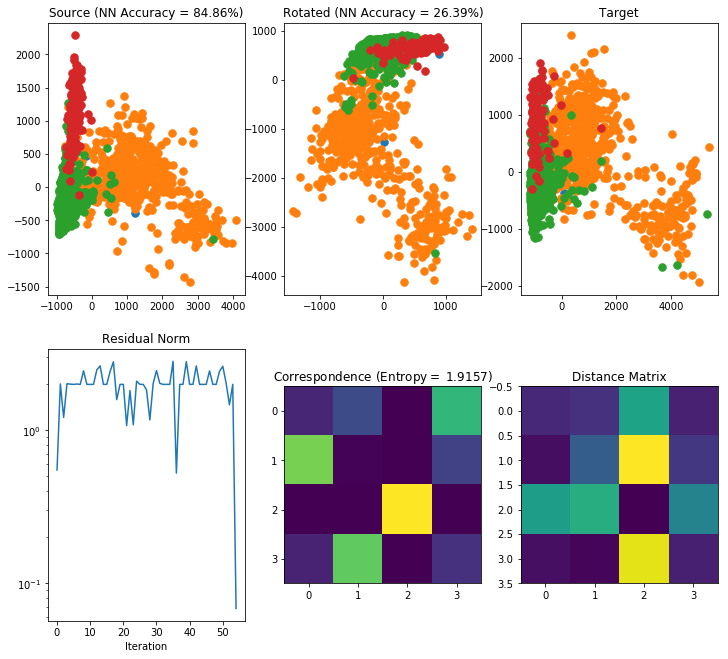

In [15]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(12, 11))
plt.subplot(2, 3, 1)
plt.title('Source (NN Accuracy = {:.2%})'.format(nn_hwa_prealign))
utils.color_data(ft1_3d, labels1)
plt.subplot(2, 3, 2)
plt.title('Rotated (NN Accuracy = {:.2%})'.format(nn_hwa))
utils.color_data(ft1_rec, labels1)
plt.subplot(2, 3, 3)
plt.title('Target')
utils.color_data(ft2_3d, labels2)
ax = plt.subplot(2, 3, 4)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(2, 3, 5)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(2, 3, 6)
plt.title('Distance Matrix')
c = plt.imshow(hwa.diagnostics['C'])

### Example D - Embed data in higher dimension first and then learn low-d mapping

#### Step 1. Try to first embed data in 5D and then solve matching in 2D

In [16]:
# We're not limited to matching in 3D
pca = PCA(n_components=5)
ft1_5d = pca.fit_transform(ft1)
ft2_5d = pca.fit_transform(ft2)

#### Step 2. Run HiWA

In [17]:
# Fit the model and transform the source dataset
t1 = time.time()
hwa = hiwa.HiWA(dim_red_method=PCA(n_components=2), normalize=True)
ft2_rec = hwa.fit_transform(ft2_5d, labels2, ft1_5d, labels1)
t2 = time.time()

print('Time elapsed: {:.4f} seconds'.format(t2 - t1))

Time elapsed: 113.5048 seconds


#### Step 3. Compute accuracy

In [19]:
nbrs = NearestNeighbors()
nbrs.fit(ft2_5d)
idx = nbrs.kneighbors(ft1_5d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa_prealign = (labels1[idx] == labels2).sum() / labels2.shape[0]

nbrs = NearestNeighbors()
nbrs.fit(ft2_rec)
idx = nbrs.kneighbors(ft1_5d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa = (labels1[idx] == labels2).sum() / labels2.shape[0]

print('NN Accuracy (Before): {:.2%}'.format(nn_hwa_prealign))
print('NN Accuracy (After): {:.2%}'.format(nn_hwa))

NN Accuracy (Before): 43.82%
NN Accuracy (After): 51.94%


#### Step 4. Visualize results 

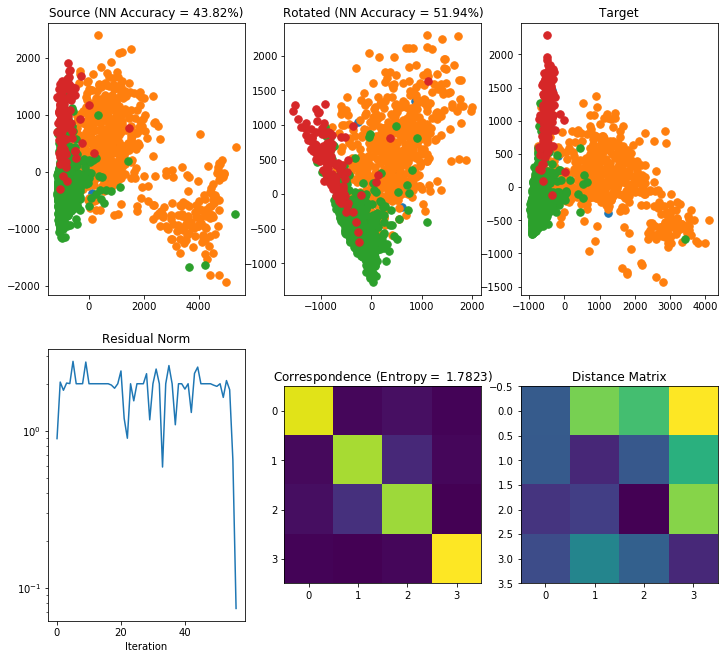

In [20]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(12, 11))
plt.subplot(2, 3, 1)
plt.title('Source (NN Accuracy = {:.2%})'.format(nn_hwa_prealign))
utils.color_data(ft2_5d, labels2)
plt.subplot(2, 3, 2)
plt.title('Rotated (NN Accuracy = {:.2%})'.format(nn_hwa))
utils.color_data(ft2_rec, labels2)
plt.subplot(2, 3, 3)
plt.title('Target')
utils.color_data(ft1_5d, labels1)
ax = plt.subplot(2, 3, 4)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(2, 3, 5)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(2, 3, 6)
plt.title('Distance Matrix')
c = plt.imshow(hwa.diagnostics['C'])